In [1]:
#Importamos las librerias que usaremos en este practica

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer #importar librerias de imputacion
from sklearn.preprocessing import OneHotEncoder,StandardScaler,OrdinalEncoder
from sklearn.pipeline import Pipeline #libreria para pipelines
from sklearn.pipeline import make_pipeline 
from sklearn.compose import ColumnTransformer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer


from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import VarianceThreshold

import sklearn.metrics as skm
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis #LDA
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import roc_auc_score, f1_score

from time import time
from datetime import timedelta

#importar libreria para leer yaml
import os
import re
import yaml

###
import pickle #Libreria para guardar modelos

#Manejo de Warnings
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid")
sns.set_style('whitegrid')


###propias
from TukeysOutlierReplacer import TukeysOutlierReplacer

In [2]:
root = re.findall('.*Taller_Practico', os.getcwd())[0]
os.chdir(root)

In [3]:
# Ruta al archivo YAML relativa al directorio encontrado
yaml_file_path = os.path.join(root, 'config.yaml')
#print(yaml_file_path)

### Lectura de datos preparados

In [4]:
with open(yaml_file_path, 'r') as file:
    config = yaml.safe_load(file)

parquet_path = config['data_path']['stage_processed'] + '/cancer_processed.parquet'
df_parquet = pd.read_parquet(parquet_path)


### definicion de cual será el que se usará
df = df_parquet
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3955 entries, 2987 to 898
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   GENERO                      3955 non-null   object        
 1   ESTADO_CIVIL                3955 non-null   object        
 2   FECHA_NACIMIENTO            3955 non-null   datetime64[ns]
 3   CODIGO_SEDE                 3955 non-null   object        
 4   MULTI_CANCER                3955 non-null   float64       
 5   CESION                      3955 non-null   object        
 6   RIESGOS                     3955 non-null   float64       
 7   CANCER_MAMA_FAMILIAR        3955 non-null   object        
 8   CANCER_OTRO_SITIO           3955 non-null   object        
 9   CANCER_OTRO_SITIO_FAMILIAR  3955 non-null   object        
 10  CEREBRAL_FAMILIAR           3955 non-null   object        
 11  FECHA_DATOS_PESO_TALLA      3955 non-null   datetime64

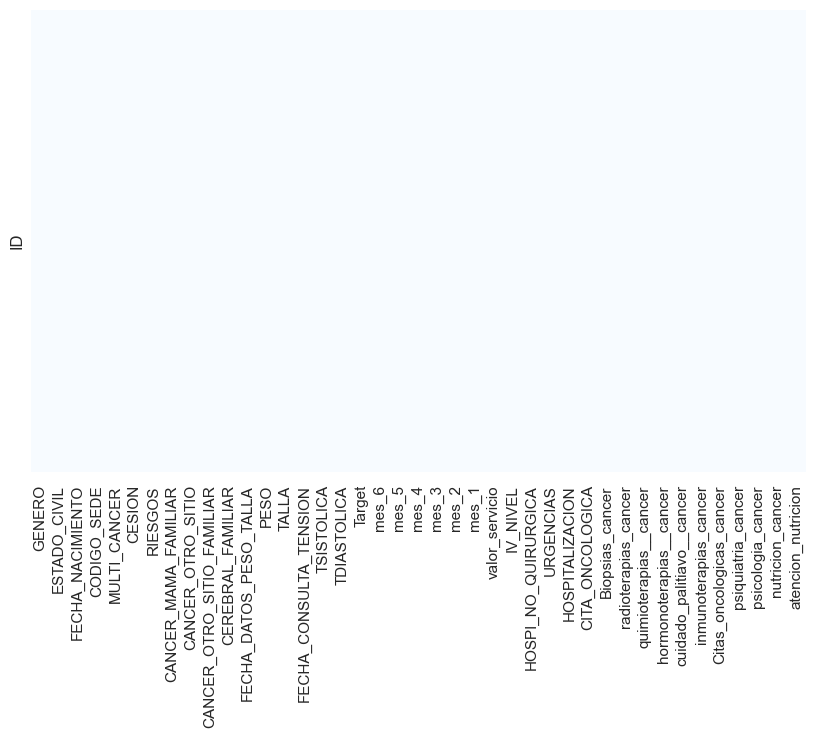

In [5]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap="Blues")
plt.show()

In [6]:
def add_model(data_pipeline, model) -> Pipeline:
    whole_pipeline = Pipeline([
        ("data_pipeline", data_pipeline),
        ("model", model)
    ])
    return whole_pipeline


### Definicion de variable Target

In [7]:
X, y = df.drop(columns="Target"), df["Target"]
y.value_counts(True) * 100

0.0    88.697851
1.0    11.302149
Name: Target, dtype: float64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
categoricas = X_train.select_dtypes('object').columns
categoricas = categoricas.delete(
    categoricas.isin(['CODIGO_SEDE','atencion_nutricion'])
)

numericas = X_train.select_dtypes('number').columns

In [10]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), 
           ("scaler", StandardScaler()),
           ("select_var", VarianceThreshold(0.1))]
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop="if_binary")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numericas),
        ("cat", categorical_transformer, categoricas),
    ]
)

### Modelo RLPCA

Preparacion de informacion para PCA, para encontrar el mejor numero de componentes que expliquen el 90 % de la informacion del data set

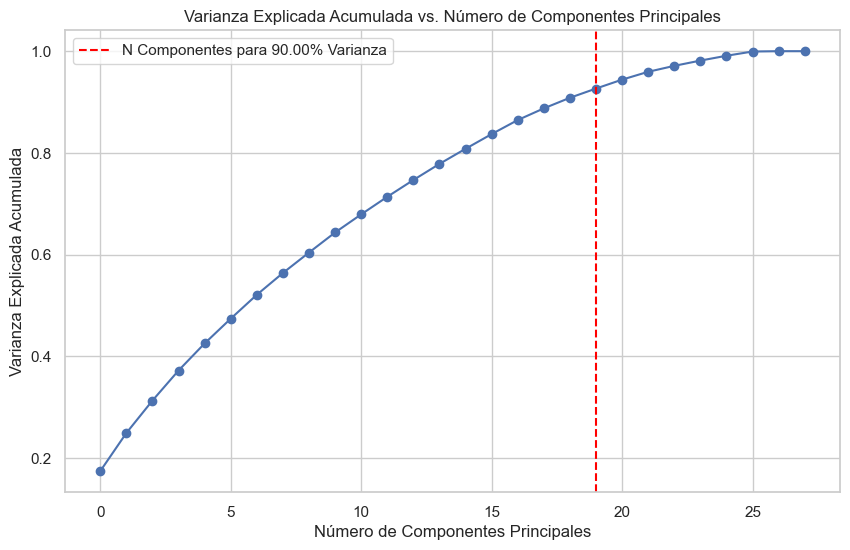

Número de componentes para alcanzar 90.0 % de varianza explicada: 19


In [11]:
numeric_transformer = Pipeline(
    steps=[("imputer",  SimpleImputer(strategy='mean')),
           ("scaler", StandardScaler()),
           ("select_var", VarianceThreshold(0.1))
          ]
)

X_scaled = numeric_transformer.fit_transform(X[numericas])

# Inicializar el modelo PCA
pca = PCA()

pca.fit(X_scaled)

# Varianza explicada acumulada
explained_variance_ratio_cumulative = np.cumsum(pca.explained_variance_ratio_)

# Encuentra el número de componentes para alcanzar un porcentaje de varianza explicada deseado
target_variance = 0.90  

n_components_to_reach_variance = np.argmax(explained_variance_ratio_cumulative >= target_variance) + 1

# Graficar la varianza explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(explained_variance_ratio_cumulative, marker='o')
plt.axvline(n_components_to_reach_variance, color='red', linestyle='--', label=f'N Componentes para {target_variance*100:.2f}% Varianza')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada Acumulada vs. Número de Componentes Principales')
plt.legend()
plt.grid(True)
plt.show()

print('Número de componentes para alcanzar', target_variance*100, '% de varianza explicada:', n_components_to_reach_variance)

In [12]:
data_pipeline = Pipeline(steps=[
    ("data_processor", preprocessor),
    ("pca", PCA( n_components=19))
])

pipeline = add_model(data_pipeline, LogisticRegression()) ## SVC(**model_kwargs)

In [13]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_pipeline',
                 Pipeline(steps=[('data_processor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler()),
                                                                                   ('select_var',
                                                                                    VarianceThreshold(threshold=0.1))]),
                                                                   Index(['MULTI_CANCER', 'RIESGOS', 'PESO', 'TALLA', 'TSISTOLICA', 'TDIASTOLICA',
       'mes_6', 'mes_5', 'mes_4', 'mes_3', 'mes_2', 'mes_1',...
       'Citas_oncologicas_cancer', 'psiquiatria_cancer', 'psicologia_cancer',
       'nutricion_cancer'],
      dtype='object')),
                                                                  ('cat',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'),
                                                                   Index(['GENERO', 'ESTADO_CIVIL', 'CESION', 'CANCER_MAMA_FAMILIAR',
       'CANCER_OTRO_SITIO', 'CANCER_OTRO_SITIO_FAMILIAR', 'CEREBRAL_FAMILIAR'],
      dtype='object'))])),
                                 ('pca', PCA(n_components=19))])),
                ('model', LogisticRegression())])

In [14]:
with open("pipeline_model_rlpac.pkl", "wb") as f:
    pickle.dump(pipeline, f)

In [15]:
test_preds = pipeline.predict(X_test)
train_preds = pipeline.predict(X_train)

In [16]:
pd.DataFrame(test_preds).value_counts()

0.0    754
1.0     37
dtype: int64

In [17]:
test_preds = pipeline.predict_proba(X_test)[:, 1]
train_preds = pipeline.predict_proba(X_train)[:, 1]
ths = np.linspace(0, 1, 1000)
best_th = ths[np.argmax([f1_score(y_test, test_preds>th) for th in ths])]
best_th

0.21621621621621623

In [18]:
test_f1 = f1_score(y_test, test_preds>best_th)
train_f1 = f1_score(y_train, train_preds>best_th)
print(f"Train f1: {train_f1}")
print(f"Test f1: {test_f1}")


Train f1: 0.5027322404371584
Test f1: 0.5668449197860963


In [19]:
pipeline.fit(X, y)

Pipeline(steps=[('data_pipeline',
                 Pipeline(steps=[('data_processor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler()),
                                                                                   ('select_var',
                                                                                    VarianceThreshold(threshold=0.1))]),
                                                                   Index(['MULTI_CANCER', 'RIESGOS', 'PESO', 'TALLA', 'TSISTOLICA', 'TDIASTOLICA',
       'mes_6', 'mes_5', 'mes_4', 'mes_3', 'mes_2', 'mes_1',...
       'Citas_oncologicas_cancer', 'psiquiatria_cancer', 'psicologia_cancer',
       'nutricion_cancer'],
      dtype='object')),
                                                                  ('cat',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'),
                                                                   Index(['GENERO', 'ESTADO_CIVIL', 'CESION', 'CANCER_MAMA_FAMILIAR',
       'CANCER_OTRO_SITIO', 'CANCER_OTRO_SITIO_FAMILIAR', 'CEREBRAL_FAMILIAR'],
      dtype='object'))])),
                                 ('pca', PCA(n_components=19))])),
                ('model', LogisticRegression())])

In [20]:
with open(yaml_file_path, 'r') as file:
    config = yaml.safe_load(file)

parquet_path = config['data_path']['github_parquet_test']
test_df = pd.read_parquet(parquet_path)
submission_pred = pipeline.predict_proba(test_df)[:, 1]
submission_pred_bool = submission_pred>best_th
submission_pred_int = [int(item) for item in submission_pred_bool]
submission = pd.DataFrame(data=dict(ID=test_df.index, Target=submission_pred_int))
submission.to_csv("submission_modelrlpca.csv", index=False)

### Modelo RL

In [21]:
data_pipeline = Pipeline(steps=[
    ("data_processor", preprocessor),
    #("pca", PCA()),
])

pipeline = add_model(data_pipeline, LogisticRegression()) ## SVC(**model_kwargs)

In [22]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_pipeline',
                 Pipeline(steps=[('data_processor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler()),
                                                                                   ('select_var',
                                                                                    VarianceThreshold(threshold=0.1))]),
                                                                   Index(['MULTI_CANCER', 'RIESGOS', 'PESO', 'TALLA', 'TSISTOLICA', 'TDIASTOLICA',
       'mes_6', 'mes_5', 'mes_4', 'mes_3', 'mes_2', 'mes_1',...
       'Citas_oncologicas_cancer', 'psiquiatria_cancer', 'psicologia_cancer',
       'nutricion_cancer'],
      dtype='object')),
                                                                  ('cat',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'),
                                                                   Index(['GENERO', 'ESTADO_CIVIL', 'CESION', 'CANCER_MAMA_FAMILIAR',
       'CANCER_OTRO_SITIO', 'CANCER_OTRO_SITIO_FAMILIAR', 'CEREBRAL_FAMILIAR'],
      dtype='object'))]))])),
                ('model', LogisticRegression())])

In [23]:
with open("pipeline_model_rl.pkl", "wb") as f:
    pickle.dump(pipeline, f)

In [24]:
test_preds = pipeline.predict(X_test)
train_preds = pipeline.predict(X_train)

In [25]:
pd.DataFrame(test_preds).value_counts()

0.0    751
1.0     40
dtype: int64

In [26]:
test_preds = pipeline.predict_proba(X_test)[:, 1]
train_preds = pipeline.predict_proba(X_train)[:, 1]
ths = np.linspace(0, 1, 1000)
best_th = ths[np.argmax([f1_score(y_test, test_preds>th) for th in ths])]
best_th

0.3053053053053053

In [27]:
test_f1 = f1_score(y_test, test_preds>best_th)
train_f1 = f1_score(y_train, train_preds>best_th)
print(f"Train f1: {train_f1}")
print(f"Test f1: {test_f1}")


Train f1: 0.49918962722852517
Test f1: 0.5526315789473685


In [28]:
pipeline.fit(X, y)

Pipeline(steps=[('data_pipeline',
                 Pipeline(steps=[('data_processor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler()),
                                                                                   ('select_var',
                                                                                    VarianceThreshold(threshold=0.1))]),
                                                                   Index(['MULTI_CANCER', 'RIESGOS', 'PESO', 'TALLA', 'TSISTOLICA', 'TDIASTOLICA',
       'mes_6', 'mes_5', 'mes_4', 'mes_3', 'mes_2', 'mes_1',...
       'Citas_oncologicas_cancer', 'psiquiatria_cancer', 'psicologia_cancer',
       'nutricion_cancer'],
      dtype='object')),
                                                                  ('cat',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'),
                                                                   Index(['GENERO', 'ESTADO_CIVIL', 'CESION', 'CANCER_MAMA_FAMILIAR',
       'CANCER_OTRO_SITIO', 'CANCER_OTRO_SITIO_FAMILIAR', 'CEREBRAL_FAMILIAR'],
      dtype='object'))]))])),
                ('model', LogisticRegression())])

In [29]:
with open(yaml_file_path, 'r') as file:
    config = yaml.safe_load(file)

parquet_path = config['data_path']['github_parquet_test']
test_df = pd.read_parquet(parquet_path)
submission_pred = pipeline.predict_proba(test_df)[:, 1]
submission_pred_bool = submission_pred>best_th
submission_pred_int = [int(item) for item in submission_pred_bool]
submission = pd.DataFrame(data=dict(ID=test_df.index, Target=submission_pred_int))
submission.to_csv("submission_modelrl.csv", index=False)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3955 entries, 2987 to 898
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   GENERO                      3955 non-null   object        
 1   ESTADO_CIVIL                3955 non-null   object        
 2   FECHA_NACIMIENTO            3955 non-null   datetime64[ns]
 3   CODIGO_SEDE                 3955 non-null   object        
 4   MULTI_CANCER                3955 non-null   float64       
 5   CESION                      3955 non-null   object        
 6   RIESGOS                     3955 non-null   float64       
 7   CANCER_MAMA_FAMILIAR        3955 non-null   object        
 8   CANCER_OTRO_SITIO           3955 non-null   object        
 9   CANCER_OTRO_SITIO_FAMILIAR  3955 non-null   object        
 10  CEREBRAL_FAMILIAR           3955 non-null   object        
 11  FECHA_DATOS_PESO_TALLA      3955 non-null   datetime64

### Naive Bayes

In [31]:
nb_pipeline = Pipeline([
    ('preprocesamiento', preprocessor),
    ("pca", PCA( n_components=19))
])

pipeline = add_model(nb_pipeline, GaussianNB()) ## SVC(**model_kwargs)
pipeline.fit(X_train, y_train)
with open("pipeline_model_nb.pkl", "wb") as f:
    pickle.dump(pipeline, f)
test_preds = pipeline.predict(X_test)
train_preds = pipeline.predict(X_train)    
test_preds = pipeline.predict_proba(X_test)[:, 1]
train_preds = pipeline.predict_proba(X_train)[:, 1]
ths = np.linspace(0, 1, 1000)
best_th = ths[np.argmax([f1_score(y_test, test_preds>th) for th in ths])]
print(best_th,f'\n')
test_f1 = f1_score(y_test, test_preds>best_th)
train_f1 = f1_score(y_train, train_preds>best_th)
print(f"Train f1: {train_f1}")
print(f"Test f1: {test_f1}")
pipeline.fit(X, y)

0.035035035035035036 

Train f1: 0.45333333333333337
Test f1: 0.45945945945945943


Pipeline(steps=[('data_pipeline',
                 Pipeline(steps=[('preprocesamiento',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler()),
                                                                                   ('select_var',
                                                                                    VarianceThreshold(threshold=0.1))]),
                                                                   Index(['MULTI_CANCER', 'RIESGOS', 'PESO', 'TALLA', 'TSISTOLICA', 'TDIASTOLICA',
       'mes_6', 'mes_5', 'mes_4', 'mes_3', 'mes_2', 'mes_1...
       'Citas_oncologicas_cancer', 'psiquiatria_cancer', 'psicologia_cancer',
       'nutricion_cancer'],
      dtype='object')),
                                                                  ('cat',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'),
                                                                   Index(['GENERO', 'ESTADO_CIVIL', 'CESION', 'CANCER_MAMA_FAMILIAR',
       'CANCER_OTRO_SITIO', 'CANCER_OTRO_SITIO_FAMILIAR', 'CEREBRAL_FAMILIAR'],
      dtype='object'))])),
                                 ('pca', PCA(n_components=19))])),
                ('model', GaussianNB())])

In [32]:
with open(yaml_file_path, 'r') as file:
    config = yaml.safe_load(file)

parquet_path = config['data_path']['github_parquet_test']
test_df = pd.read_parquet(parquet_path)
submission_pred = pipeline.predict_proba(test_df)[:, 1]
submission_pred_bool = submission_pred>best_th
submission_pred_int = [int(item) for item in submission_pred_bool]
submission = pd.DataFrame(data=dict(ID=test_df.index, Target=submission_pred_int))
submission.to_csv("submission_modelnb.csv", index=False)

### XGBOOST

In [33]:
xgb_preprocessing = ColumnTransformer([
    ('preprocesamiento', preprocessor, X_train.columns)
])

In [34]:
config_xgb = dict(
    use_label_encoder=False, eval_metric='logloss'
)

In [35]:
pipeline = add_model(xgb_preprocessing, XGBClassifier(**config_xgb)) ## SVC(**model_kwargs)
pipeline.fit(X_train, y_train)
with open("pipeline_model_xgboost.pkl", "wb") as f:
    pickle.dump(pipeline, f)
test_preds = pipeline.predict(X_test)
train_preds = pipeline.predict(X_train)    
test_preds = pipeline.predict_proba(X_test)[:, 1]
train_preds = pipeline.predict_proba(X_train)[:, 1]
ths = np.linspace(0, 1, 1000)
best_th = ths[np.argmax([f1_score(y_test, test_preds>th) for th in ths])]
print(best_th,f'\n')
test_f1 = f1_score(y_test, test_preds>best_th)
train_f1 = f1_score(y_train, train_preds>best_th)
print(f"Train f1: {train_f1}")
print(f"Test f1: {test_f1}")
pipeline.fit(X, y)

0.5245245245245245 

Train f1: 0.9985935302390998
Test f1: 0.5599999999999999


Pipeline(steps=[('data_pipeline',
                 ColumnTransformer(transformers=[('preprocesamiento',
                                                  ColumnTransformer(transformers=[('num',
                                                                                   Pipeline(steps=[('imputer',
                                                                                                    SimpleImputer()),
                                                                                                   ('scaler',
                                                                                                    StandardScaler()),
                                                                                                   ('select_var',
                                                                                                    VarianceThreshold(threshold=0.1))]),
                                                                                   Index(['MULTI_CANCER', 'RIESGOS', 'PESO', 'TALLA', 'TSISTOLICA', 'TDIASTOLICA',
       'mes_6', 'mes_5', 'mes_4', 'mes_3...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [36]:
with open(yaml_file_path, 'r') as file:
    config = yaml.safe_load(file)

parquet_path = config['data_path']['github_parquet_test']
test_df = pd.read_parquet(parquet_path)
submission_pred = pipeline.predict_proba(test_df)[:, 1]
submission_pred_bool = submission_pred>best_th
submission_pred_int = [int(item) for item in submission_pred_bool]
submission = pd.DataFrame(data=dict(ID=test_df.index, Target=submission_pred_int))
submission.to_csv("submission_modelxgboost.csv", index=False)

### SVC Lineal Grid Search
usando PCA

In [ ]:
#encontrando los mejores parametros de SVC

In [95]:
parametros = [{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}]
start = time()
clf = GridSearchCV(SVC(kernel='linear', probability=True), # el modelo a configurar para definir los valores del hiperparametro C que quiero testear
                   parametros, # los parámetros con los valores a ensayar
                   cv=3, # para cada modelo se hacen 10 repeticiones
                   scoring='f1', # métrica de evaluación a considerar para decidir el mejor modelo
                   return_train_score=True) # guardar en memoria los valores de las métricas de evaluación

end = time()



In [100]:
clf.best_params_

{'C': 1}

In [96]:
svc_pipeline = Pipeline([
    ('preprocesamiento', preprocessor),
    ("pca", PCA( n_components=19))
])

In [97]:
pipeline = add_model(svc_pipeline, clf) ## SVC(**model_kwargs)
start = time()
pipeline.fit(X_train, y_train)
end = time()
with open("submission_model_gridsearch_scv.pkl", "wb") as f:
    pickle.dump(pipeline, f)
test_preds = pipeline.predict(X_test)
train_preds = pipeline.predict(X_train)    
test_preds = pipeline.predict_proba(X_test)[:, 1]
train_preds = pipeline.predict_proba(X_train)[:, 1]
ths = np.linspace(0, 1, 1000)
best_th = ths[np.argmax([f1_score(y_test, test_preds>th) for th in ths])]
print(best_th,f'\n')
test_f1 = f1_score(y_test, test_preds>best_th)
train_f1 = f1_score(y_train, train_preds>best_th)
print(f"Train f1: {train_f1}")
print(f"Test f1: {test_f1}")
pipeline.fit(X, y)

print(
    'Tiempo Entrenamiento SVC GridSearch:',
    str(timedelta(seconds=end-start))
)


0.2082082082082082 

Train f1: 0.5
Test f1: 0.5942028985507247
Tiempo Entrenamiento SVC GridSearch: 0:14:45.645616


In [98]:
with open(yaml_file_path, 'r') as file:
    config = yaml.safe_load(file)

parquet_path = config['data_path']['github_parquet_test']
test_df = pd.read_parquet(parquet_path)
submission_pred = pipeline.predict_proba(test_df)[:, 1]
submission_pred_bool = submission_pred>best_th
submission_pred_int = [int(item) for item in submission_pred_bool]
submission = pd.DataFrame(data=dict(ID=test_df.index, Target=submission_pred_int))
submission.to_csv("submission_model_gridsearch_scv.csv", index=False)

### SVC LinealSVC

In [37]:
class LDATransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        self.clf = LinearDiscriminantAnalysis()
        self.clf.fit(X,y) 
        return self

    def transform(self, X, y=None):
      # Perform arbitary transformation
        X_transformed = X.copy()
        lda = pd.DataFrame(self.clf.transform(X_transformed)).rename(columns={0:'LDA'})
        X_transformed=pd.DataFrame(X_transformed)
        X_transformed = pd.concat([X_transformed,lda],axis=1)
        return X_transformed

In [38]:
Imputer = SimpleImputer(strategy="mean") # le estoy diciendo cual es la media para imputar
Scaler = MinMaxScaler() # se puede poner el minmaxscaler, robustscaler o otros # resto la media y divido la desviacion estandar
LDA = LinearDiscriminantAnalysis()

In [39]:
X_num = X[numericas].copy()

In [40]:
Imputer.fit(X_num)
X_num_proces = Imputer.transform(X_num)

In [41]:
Scaler.fit(X_num_proces)
X_num_proces = Scaler.transform(X_num_proces)

In [42]:
LDA.fit(X_num_proces,y)

LinearDiscriminantAnalysis()

In [43]:
X_num_proces = LDA.transform(X_num_proces) ## tambien podria tenerse todos los antesriores y agregar el lda como columna adicional

In [44]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler()), ("LDA_feature",LDATransformer())]
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop="if_binary")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numericas),
        ("cat", categorical_transformer, categoricas),
    ]
)

In [45]:
preprocessor.fit(X,y)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler()),
                                                 ('LDA_feature',
                                                  LDATransformer())]),
                                 Index(['MULTI_CANCER', 'RIESGOS', 'PESO', 'TALLA', 'TSISTOLICA', 'TDIASTOLICA',
       'mes_6', 'mes_5', 'mes_4', 'mes_3', 'mes_2', 'mes_1', 'valor_servicio',
       'IV_NIVEL', 'HOSPI_NO_QUIRURGICA', 'URGENCIAS', 'HOSPITALIZACION',
       'C...
       'cuidado_palitiavo__cancer', 'inmunoterapias_cancer',
       'Citas_oncologicas_cancer', 'psiquiatria_cancer', 'psicologia_cancer',
       'nutricion_cancer'],
      dtype='object')),
                                ('cat',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore'),
                                 Index(['GENERO', 'ESTADO_CIVIL', 'CESION', 'CANCER_MAMA_FAMILIAR',
       'CANCER_OTRO_SITIO', 'CANCER_OTRO_SITIO_FAMILIAR', 'CEREBRAL_FAMILIAR'],
      dtype='object'))])

In [46]:
X_a=preprocessor.transform(X)

#### Optimizacion Bayesiana

In [51]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import numpy as np
import collections
%matplotlib inline

def live_plot(data_dict, figsize=(7,5), title='', win_size: int = 100):
    """
    Función para mostrar en tiempo real el progreso de la optmización bayesiana.
    """
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        if len(data) > win_size:
            data = data[-win_size:]
            iterations = np.arange(len(data))[-win_size:] 
        else:
            iterations = np.arange(len(data))
        plt.plot(iterations, data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('Iteration')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show();

In [92]:
data = collections.defaultdict(list)

def train_and_evaluate(
    # Data 
    scaler_choice,
    imputer_strategy,
    knn_imputer,
    knn_imputer_k,

    #Modelo SVC
    SVC_C,
    SVC_gamma,
    kernel_SVC='linear'

) -> float:
    scaler_cls = StandardScaler if scaler_choice > 0.5 else MinMaxScaler
    imputer_strategy = "mean" if imputer_strategy > 0.5 else "median"
    if knn_imputer > 0.5:
        imputer = KNNImputer(n_neighbors=int(knn_imputer_k))
    else:
        imputer = SimpleImputer(strategy=imputer_strategy)
    
    numeric_transformer = Pipeline(
        steps=[("imputer", imputer), 
               ("scaler", scaler_cls())#,
               #("LDA_feature",LDATransformer())
              ]
    )
    
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numericas),
            ("cat", categorical_transformer, categoricas),
        ]
    )
    
    data_pipeline = Pipeline(steps=[
        ("data_processor", preprocessor),
    ])
           
    #Model SVM
    model = SVC(C=SVC_C, gamma=SVC_gamma, kernel=kernel_SVC, probability=True)
    pipeline = add_model(data_pipeline, model)
    show_live_plot=True

    ## Training protocol
    
    kf = KFold(n_splits=3, random_state=963, shuffle=True)
    
    train_fold_metrics = [] 
    val_fold_metrics = []

    # K-Fold cross val
    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        #print(f"Fold number: {i+1}")
        kX_train, kX_val = X_train.iloc[train_index], X_train.iloc[test_index]
        ky_train, ky_val = y_train.iloc[train_index], y_train.iloc[test_index]
        #print(f"Training with {kX_train.shape}")
        #print(f"Validating with {kX_val.shape}")
        pipeline.fit(kX_train, ky_train)
        
        val_preds = pipeline.predict_proba(kX_val)[:, 1]
               
        train_preds = pipeline.predict_proba(kX_train)[:, 1]
        
        ths = np.linspace(0, 1, 1000)
        best_th = ths[np.argmax([f1_score(ky_val, val_preds>th) for th in ths])]
        best_th
        
        val_f1 = f1_score(ky_val, val_preds>best_th)
        train_f1 = f1_score(ky_train, train_preds>best_th)
        
        train_fold_metrics.append(train_f1)
        val_fold_metrics.append(val_f1)            
       
    f1_train = np.array(train_fold_metrics)
    f1_val = np.array(val_fold_metrics)
    
    adj_val_f1 = ( f1_val.mean() -  f1_val.std())
    adj_train_f1 = ( f1_train.mean() -  f1_train.std())
    objective = adj_val_f1 - abs(adj_val_f1 - adj_train_f1)
    
    print(f"Validation F1 adjusted score: {adj_val_f1}")
    print(f"Train F1 adjusted score: {adj_train_f1}")
    print()
    
    if show_live_plot:
        data['train_f1'].append(adj_train_f1)
        data['val_f1'].append(adj_val_f1)
        data["objective"].append(objective)
        live_plot(data)
    
    return pipeline, objective

def target_func(**kwargs):
    model, result = train_and_evaluate(**kwargs)
    return result


In [93]:
pbounds = dict(
    # Data
    scaler_choice=(0, 1),
    imputer_strategy=(0, 1),
    knn_imputer=(0,1),
    knn_imputer_k=(3, 10),
    SVC_C=(0.001, 10),
    SVC_gamma=(0,5),
   
)

optimizer = BayesianOptimization(
    f=target_func,
    pbounds=pbounds,
    random_state=963,
    verbose=2,
)


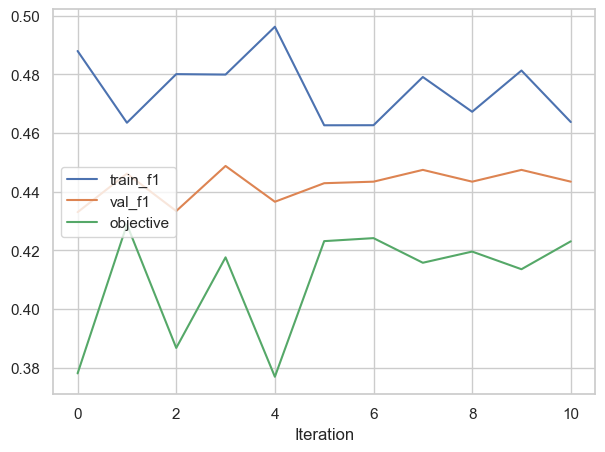

In [ ]:
logger = JSONLogger(path="./logs.json")
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

optimizer.maximize(
    n_iter=10,
)

In [55]:
optimizer.max["params"]

{'SVC_C': 6.221245506176368,
 'SVC_gamma': 0.0,
 'imputer_strategy': 0.0,
 'knn_imputer': 0.0,
 'knn_imputer_k': 6.792597687816243,
 'scaler_choice': 1.0}

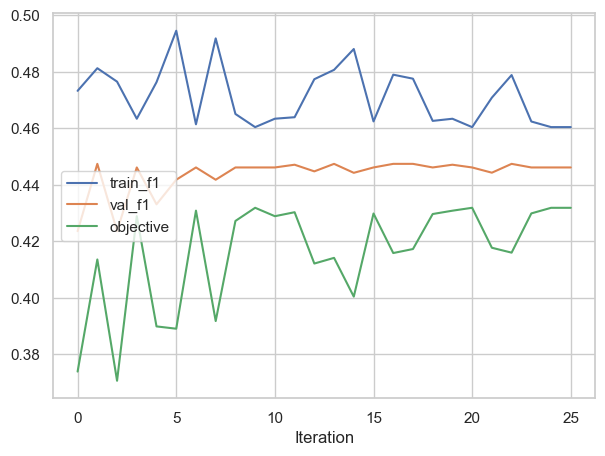

In [56]:
best_model, best_result = train_and_evaluate(**optimizer.max["params"])

In [57]:
best_model.fit(X, y)

Pipeline(steps=[('data_pipeline',
                 Pipeline(steps=[('data_processor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler()),
                                                                                   ('LDA_feature',
                                                                                    LDATransformer())]),
                                                                   Index(['MULTI_CANCER', 'RIESGOS', 'PESO', 'TALLA', 'TSISTOLICA', 'TDIASTOLICA',
       'mes_6', 'mes_5', 'mes_4', 'mes_3', 'mes_2', 'mes_1...
       'Citas_oncologicas_cancer', 'psiquiatria_cancer', 'psicologia_cancer',
       'nutricion_cancer'],
      dtype='object')),
                                                                  ('cat',
                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                   Index(['GENERO', 'ESTADO_CIVIL', 'CESION', 'CANCER_MAMA_FAMILIAR',
       'CANCER_OTRO_SITIO', 'CANCER_OTRO_SITIO_FAMILIAR', 'CEREBRAL_FAMILIAR'],
      dtype='object'))]))])),
                ('model',
                 SVC(C=6.221245506176368, gamma=0.0, kernel='linear',
                     probability=True))])

In [58]:
with open("best_model_svc_opt_by.pkl", "wb") as f:
    pickle.dump(best_model, f)

In [59]:
test_preds = best_model.predict_proba(X_test)[:, 1]
train_preds = best_model.predict_proba(X_train)[:, 1]
ths = np.linspace(0, 1, 1000)
best_th = ths[np.argmax([f1_score(y_test, test_preds>th) for th in ths])]
best_th

#0.13813813813813813

0.20020020020020018

In [60]:
test_f1 = f1_score(y_test, test_preds>best_th)
train_f1 = f1_score(y_train, train_preds>best_th)
print(f"Train f1: {train_f1}")
print(f"Test f1: {test_f1}")


#Train f1: 0.5015576323987538
#Test f1: 0.5903614457831325

Train f1: 0.5
Test f1: 0.583941605839416


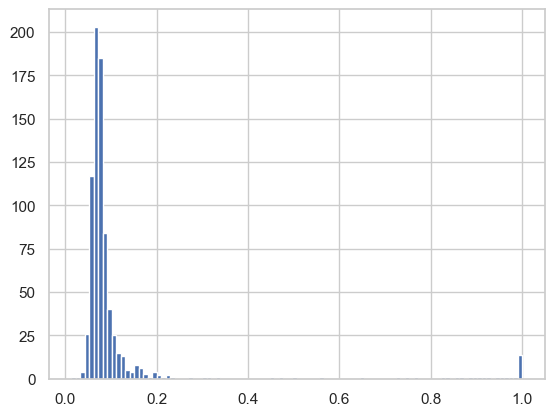

In [61]:
plt.hist(test_preds, bins=100)
plt.show()

In [62]:
with open(yaml_file_path, 'r') as file:
    config = yaml.safe_load(file)

parquet_path = config['data_path']['github_parquet_test']
test_df = pd.read_parquet(parquet_path)
submission_pred = best_model.predict_proba(test_df)[:, 1]
submission_pred_bool = submission_pred>best_th
submission_pred_int = [int(item) for item in submission_pred_bool]
submission = pd.DataFrame(data=dict(ID=test_df.index, Target=submission_pred_int))
submission.to_csv("submission_modelsvc_opt_by.csv", index=False)

### SVC rbf

In [63]:
class LDATransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        self.clf = LinearDiscriminantAnalysis()
        self.clf.fit(X,y) 
        return self

    def transform(self, X, y=None):
      # Perform arbitary transformation
        X_transformed = X.copy()
        lda = pd.DataFrame(self.clf.transform(X_transformed)).rename(columns={0:'LDA'})
        X_transformed=pd.DataFrame(X_transformed)
        X_transformed = pd.concat([X_transformed,lda],axis=1)
        return X_transformed

In [64]:
xgb_preprocessing = ColumnTransformer([
    ('procesador_numericas', 'passthrough', numericas),
    #('proccesador_ordinal', OrdinalEncoder(**config_ordinal), ordinales),
    ('procesador_categoricas', OneHotEncoder(), categoricas)
])

In [65]:
Imputer = SimpleImputer(strategy="median") # le estoy diciendo cual es la mediana para imputar
Scaler = StandardScaler() # se puede poner el minmaxscaler, robustscaler o otros # resto la media y divido la desviacion estandar
LDA = LinearDiscriminantAnalysis()

In [67]:
X_num = X[numericas].copy()

In [68]:
Imputer.fit(X_num)
X_num_proces = Imputer.transform(X_num)

In [69]:
Scaler.fit(X_num_proces)
X_num_proces = Scaler.transform(X_num_proces)

In [70]:
LDA.fit(X_num_proces,y)

LinearDiscriminantAnalysis()

In [71]:
X_num_proces = LDA.transform(X_num_proces) ## tambien podria tenerse todos los antesriores y agregar el lda como columna adicional

In [72]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler()), ("LDA_feature",LDATransformer())]
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop="if_binary")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numericas),
        ("cat", categorical_transformer, categoricas),
    ]
)

In [73]:
preprocessor.fit(X,y)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler()),
                                                 ('LDA_feature',
                                                  LDATransformer())]),
                                 Index(['MULTI_CANCER', 'RIESGOS', 'PESO', 'TALLA', 'TSISTOLICA', 'TDIASTOLICA',
       'mes_6', 'mes_5', 'mes_4', 'mes_3', 'mes_2', 'mes_1', 'valor_servicio',
       'IV_NIVEL', 'HOSPI_NO_QUIRURGICA', 'URGENCIAS', 'HOSPITALIZACION',
       'C...
       'cuidado_palitiavo__cancer', 'inmunoterapias_cancer',
       'Citas_oncologicas_cancer', 'psiquiatria_cancer', 'psicologia_cancer',
       'nutricion_cancer'],
      dtype='object')),
                                ('cat',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore'),
                                 Index(['GENERO', 'ESTADO_CIVIL', 'CESION', 'CANCER_MAMA_FAMILIAR',
       'CANCER_OTRO_SITIO', 'CANCER_OTRO_SITIO_FAMILIAR', 'CEREBRAL_FAMILIAR'],
      dtype='object'))])

In [74]:
X_a=preprocessor.transform(X)

In [75]:
data = collections.defaultdict(list)

def train_and_evaluate(
    # Data 
    scaler_choice,
    imputer_strategy,
    knn_imputer,
    knn_imputer_k,

    #Modelo SVC
    SVC_C,
    SVC_gamma,
    kernel_SVC='rbf'

) -> float:
    scaler_cls = StandardScaler if scaler_choice > 0.5 else MinMaxScaler
    imputer_strategy = "mean" if imputer_strategy > 0.5 else "median"
    if knn_imputer > 0.5:
        imputer = KNNImputer(n_neighbors=int(knn_imputer_k))
    else:
        imputer = SimpleImputer(strategy=imputer_strategy)
    
    numeric_transformer = Pipeline(
        steps=[("imputer", imputer), 
               ("scaler", scaler_cls()),
               ("LDA_feature",LDATransformer()) 
              ]
    )
    
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer,  numericas),
            ("cat", categorical_transformer, categoricas),
        ]
    )
    
    data_pipeline = Pipeline(steps=[
        ("data_processor", preprocessor),
    ])
           
    #Model SVM
    model = SVC(C=SVC_C, gamma=SVC_gamma, kernel=kernel_SVC, probability=True)
    pipeline = add_model(data_pipeline, model)
    show_live_plot=True

    ## Training protocol
    
    kf = KFold(n_splits=3, random_state=963, shuffle=True)
    
    train_fold_metrics = [] 
    val_fold_metrics = []

    # K-Fold cross val
    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        #print(f"Fold number: {i+1}")
        kX_train, kX_val = X_train.iloc[train_index], X_train.iloc[test_index]
        ky_train, ky_val = y_train.iloc[train_index], y_train.iloc[test_index]
        #print(f"Training with {kX_train.shape}")
        #print(f"Validating with {kX_val.shape}")
        pipeline.fit(kX_train, ky_train)
        
        val_preds = pipeline.predict_proba(kX_val)[:, 1]
               
        train_preds = pipeline.predict_proba(kX_train)[:, 1]
        
        ths = np.linspace(0, 1, 1000)
        best_th = ths[np.argmax([f1_score(ky_val, val_preds>th) for th in ths])]
        best_th
        
        val_f1 = f1_score(ky_val, val_preds>best_th)
        train_f1 = f1_score(ky_train, train_preds>best_th)
        
        train_fold_metrics.append(train_f1)
        val_fold_metrics.append(val_f1)            
       
    f1_train = np.array(train_fold_metrics)
    f1_val = np.array(val_fold_metrics)
    
    adj_val_f1 = ( f1_val.mean() -  f1_val.std())
    adj_train_f1 = ( f1_train.mean() -  f1_train.std())
    objective = adj_val_f1 - abs(adj_val_f1 - adj_train_f1)
    
    print(f"Validation F1 adjusted score: {adj_val_f1}")
    print(f"Train F1 adjusted score: {adj_train_f1}")
    print()
    
    if show_live_plot:
        data['train_f1'].append(adj_train_f1)
        data['val_f1'].append(adj_val_f1)
        data["objective"].append(objective)
        live_plot(data)
    
    return pipeline, objective

def target_func(**kwargs):
    model, result = train_and_evaluate(**kwargs)
    return result


In [76]:
pbounds = dict(
    # Data
    scaler_choice=(0, 1),
    imputer_strategy=(0, 1),
    knn_imputer=(0,1),
    knn_imputer_k=(3, 10),
    SVC_C=(0.001, 10),
    SVC_gamma=(0,5),
   
)

optimizer = BayesianOptimization(
    f=target_func,
    pbounds=pbounds,
    random_state=963,
    verbose=2,
)


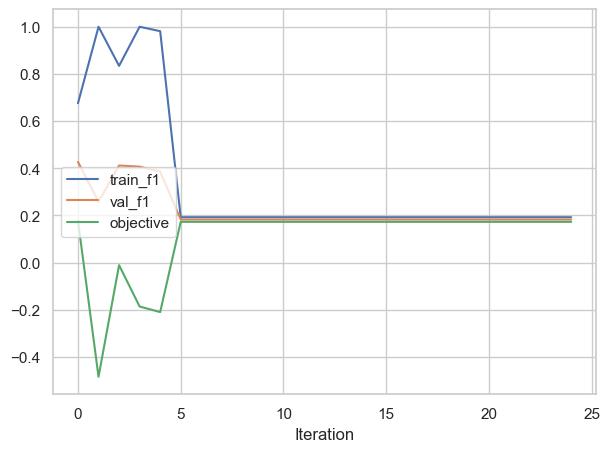

In [77]:
logger = JSONLogger(path="./logs.json")
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

optimizer.maximize(
    n_iter=20,
)

In [78]:
optimizer.max["params"]

{'SVC_C': 1.1462369146936335,
 'SVC_gamma': 0.4955447482697106,
 'imputer_strategy': 0.6675524224671163,
 'knn_imputer': 0.8089219418735465,
 'knn_imputer_k': 3.4450468548106405,
 'scaler_choice': 0.1521501966812182}

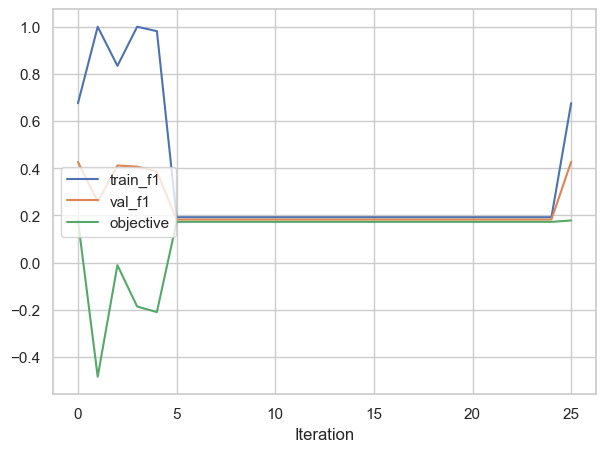

In [79]:
best_model, best_result = train_and_evaluate(**optimizer.max["params"])

In [80]:
best_model.fit(X, y)

Pipeline(steps=[('data_pipeline',
                 Pipeline(steps=[('data_processor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    KNNImputer(n_neighbors=3)),
                                                                                   ('scaler',
                                                                                    MinMaxScaler()),
                                                                                   ('LDA_feature',
                                                                                    LDATransformer())]),
                                                                   Index(['MULTI_CANCER', 'RIESGOS', 'PESO', 'TALLA', 'TSISTOLICA', 'TDIASTOLICA',
       'mes_6', 'mes_5', 'mes_4', 'mes_3', 'mes_2', 'mes_1', 'valor_...
       'Citas_oncologicas_cancer', 'psiquiatria_cancer', 'psicologia_cancer',
       'nutricion_cancer'],
      dtype='object')),
                                                                  ('cat',
                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                   Index(['GENERO', 'ESTADO_CIVIL', 'CESION', 'CANCER_MAMA_FAMILIAR',
       'CANCER_OTRO_SITIO', 'CANCER_OTRO_SITIO_FAMILIAR', 'CEREBRAL_FAMILIAR'],
      dtype='object'))]))])),
                ('model',
                 SVC(C=1.1462369146936335, gamma=0.4955447482697106,
                     probability=True))])

In [81]:
with open("best_model_svc_rbf.pkl", "wb") as f:
    pickle.dump(best_model, f)

In [82]:
test_preds = best_model.predict_proba(X_test)[:, 1]
train_preds = best_model.predict_proba(X_train)[:, 1]
ths = np.linspace(0, 1, 1000)
best_th = ths[np.argmax([f1_score(y_test, test_preds>th) for th in ths])]
best_th

#0.13813813813813813

0.09509509509509509

In [83]:
test_f1 = f1_score(y_test, test_preds>best_th)
train_f1 = f1_score(y_train, train_preds>best_th)
print(f"Train f1: {train_f1}")
print(f"Test f1: {test_f1}")


#Train f1: 0.5015576323987538
#Test f1: 0.5903614457831325

Train f1: 0.7269984917043741
Test f1: 0.7544910179640718


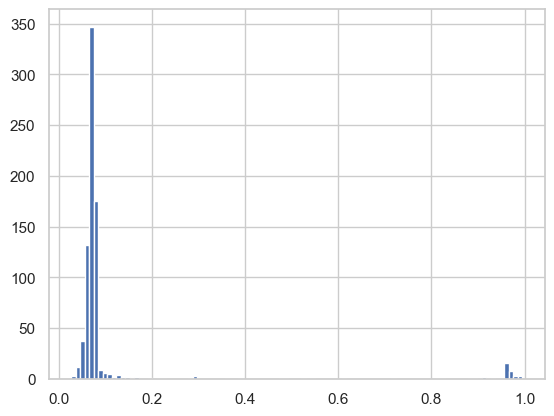

In [84]:
plt.hist(test_preds, bins=100)
plt.show()

In [85]:
with open(yaml_file_path, 'r') as file:
    config = yaml.safe_load(file)

parquet_path = config['data_path']['github_parquet_test']
test_df = pd.read_parquet(parquet_path)
submission_pred = best_model.predict_proba(test_df)[:, 1]
submission_pred_bool = submission_pred>best_th
submission_pred_int = [int(item) for item in submission_pred_bool]
submission = pd.DataFrame(data=dict(ID=test_df.index, Target=submission_pred_int))
submission.to_csv("submission_modelsvc_rbf.csv", index=False)

### Red Neuronal Poco Profunda

In [99]:
xgb_preprocessing = ColumnTransformer([
    ('procesador_numericas', 'passthrough', numericas),
    #('proccesador_ordinal', OrdinalEncoder(**config_ordinal), ordinales),
    ('procesador_categoricas', OneHotEncoder(), categoricas)
])